# TM10007 Assignment template

In [4]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [5]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 186
The number of columns: 494


**Checking for missing data**

In [6]:
# A test if missing data is found correctly
# print(data.iloc[5:8, 1:2])
# data.iloc[5:8, 1:2] = None
# print(data.iloc[5:8, 1:2])

# Checking for missing data, returning specific column and row that is missing
missing_data_total = data.isna().sum().sum()
rows_with_missing = data[data.isna().any(axis=1)]
print(f'Total amount of missing data: {missing_data_total}')
for index, row in rows_with_missing.iterrows():
    missing_columns = row[row.isna()].index
    print(f"Data missing in row: {index}, and column: {', '.join(missing_columns)}")

Total amount of missing data: 0


**Imports**

Import all modules necessary for this Jupyter Notebook


In [51]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import datasets as ds

#feature Selection
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Basic Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


**Definitions applied in this Jupyter Notebook**

In [8]:
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


**Data Visualization**

In [7]:
# Code for data visualization


**PRE PROCESSING**

Pre processing contains the following: ...

In [9]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold

# Pre processing
#
# Splitting
df_data = pd.DataFrame(data)
X = df_data.iloc[:, 1:]  # Feature set
y = df_data.iloc[:, :1]  # Classification Benign/Malignant

# Change classification (Benign/Malignant) to binary values
y['label'] = y.replace({'benign': 0, 'malignant': 1})

# Stratified K-Fold Split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Splitting data in Test and Train set
for train_index, test_index in skf.split(X, y):
    X_pre_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_pre_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Splitting data in Train and validation set
for train_index, test_index in skf.split(X_pre_train, y_pre_train):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

# print(y_train)
# print(f'The number of samples: {len(y_train)}')
# print(f'test{y_test}')
# print(f'The number of samples: {len(y_test)}')
# print(f'val{y_val}')
# print(f'The number of samples: {len(y_val)}')


<ipython-input-9-fcfbe0828860>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['label'] = y.replace({'benign': 0, 'malignant': 1})


**Scaling**

In [10]:
# Scaling

# # General packages
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# import seaborn

# # Classifiers
# from sklearn import model_selection
# from sklearn import metrics
# from sklearn import feature_selection
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import svm

# from sklearn import decomposition

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)

y_train_scaled = y_train['label'].values

# # Feature selection
# # Create the RFE object and compute a cross-validated score.
# svc = svm.SVC(kernel="linear")

# # classifications
# rfecv = feature_selection.RFECV(
#     estimator=svc, step=1,
#     cv=model_selection.StratifiedKFold(4),
#     scoring='roc_auc')
# rfecv.fit(X, y)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
# plt.show()

# Perform a PCA
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) #Waarom staat hier de test set???

y_train_list = y_train['label'].tolist()
print(y_train_list)



[[ 0.94352879 -0.98601311  0.61787628 ... -0.32181343 -0.84659553
   0.24217842]
 [ 0.24547317 -0.23475841  0.85830245 ...  0.13228887 -0.92318971
   0.91654734]
 [ 0.28643264 -0.22331008 -0.19589509 ... -0.45398148  0.26261181
  -0.31373541]
 ...
 [ 0.9785928  -0.73462397 -0.49196718 ... -0.54232872 -0.92318971
  -0.55235085]
 [-0.5425542   2.55818432 -0.36556292 ... -0.48036377 -0.06022181
   0.05117112]
 [ 0.23019558 -0.3527302  -0.07494348 ... -0.51519997 -0.46519492
  -0.28835371]]
[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]


# Feature Selection

##Unsupervised


In [31]:
#Drop Incomplete features
X_selection = X.dropna(axis=1)
#Drop high multicollinearity; multicollinearity means a strong correlation between different features, which might signal redundancy issues.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = [variance_inflation_factor(X.values, feature)for feature in range(len(X.columns))]
#Drop Zero or near-zero variance; Features that are (almost) constant provide little information to learn from and thus are irrelevant.
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)
X_selection = sel.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


##Supervised feature selection

###Embedded methods

**L1 Regularization LASSO \(least absolute shrinkage and selection operator)**

*Applies a penalty to the absolute size of the features, forcing some of them to be exactly zero. Resulting in a subset of the features to contribute in the algorithm by eliminating irrelevant features from the model indicating that these features are not contributing significantly to the model's predictive power.*

In [ ]:
###This method now prints the features selected with the lasso method to predict maligne of benigne

#Fit the model to training data
lasso = Lasso(alpha=0.01)  # 'alpha' is the regularization (= prevent overfitting) strength, higher values indicate stronger regularization
lasso.fit(X_train_scaled, y_train_scaled)

#Print selected features to be non-zero
selected_features_lasso = X.columns[lasso.coef_ != 0] #selects the features used in the model and thus relevant for predictions
print("Selected Features:", selected_features_lasso)

# Create a DataFrame containing only the selected features from the test data
selected_train_features_lasso_df = pd.DataFrame(X_train_scaled[:, lasso.coef_ != 0], columns=selected_features_lasso)
y_train_scaled_df = pd.DataFrame(y_train_scaled, index=selected_train_features_lasso_df.index, columns=['Tumor'])

# Concatenate selected features DataFrame with y_train
selected_train_data = pd.concat([selected_train_features_lasso_df, y_train_scaled_df], axis=1)

# Now selected_train_data contains the values of the selected features in separate columns
print(selected_train_data.head())  # Display the first few rows of the selected train data

#Evaluate model performance
lasso_score = lasso.score(X_train_scaled, y_train)
print("Lasso Model Score:", lasso_score)

**L2 Ridge Regularizaiton**


*Adds a penalty term proportional to the square of the coefficients,encourages smaller but non-zero coefficients for all features. Helps to reduce the impact of multicollinearity and stabilize the model meaning that when two features are highly correlated then one is given an smaller coefficient to prevent instability of the model estimates.*

In [ ]:
###This method now prints the features selected with the lasso method to predict maligne of benigne

# Fit the Ridge regression model to training data
ridge = Ridge(alpha=1)  # 'alpha' is the regularization strength, higher values indicate stronger regularization
ridge.fit(X_train_scaled, y_train_scaled)

#Print selected features (all features are used in Ridge regression)
selected_features_ridge = X.columns
print("Selected Features:", selected_features_ridge)

# Create a DataFrame containing all features from the test data
selected_train_features_ridge_df = pd.DataFrame(X_train_scaled, columns=selected_features_ridge)
y_train_scaled_df = pd.DataFrame(y_train_scaled, index=selected_train_features_ridge_df.index, columns=['Tumor'])

# Concatenate selected features DataFrame with y_train
selected_train_data = pd.concat([selected_train_features_ridge_df, y_train_scaled_df], axis=1)

# Now selected_train_data contains the values of all features along with the target variable
print(selected_train_data.head())  # Display the first few rows of the selected train data

# Visualize Ridge coefficients
def plot_coefficients(model, feature_names, title):
    coef = model.coef_.flatten()  # Coefficients need to be flattened for visualization
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_names)), coef, align='center')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

plot_coefficients(ridge, X.columns, 'Ridge Coefficients')

# Evaluate model performance
ridge_score = ridge.score(X_train_scaled, y_train)
print("Ridge Model Score:", ridge_score)


###Wrapper methods (greedy selection)

**Forward selection**

*In forward selection, we start with a null model and then start fitting the model with each individual feature one at a time and select the feature with the minimum p-value. Now fit a model with two features by trying combinations of the earlier selected feature with all other remaining features. Again select the feature with the minimum p-value. Now fit a model with three features by trying combinations of two previously selected features with other remaining features. Repeat this process until we have a set of selected features with a p-value of individual features less than the significance level.*

In [1]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=(1,10), #Selecting the number of best features???? How to determine; or is this hyperparameter tuning?
          forward=True,
          floating=False,
          scoring = 'r2', #default
          cv = 0)
sfs.fit(X_train_scaled, y_train_scaled)
sfs.k_feature_names_     # to get the final set of features

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

NameError: name 'X_train_scaled' is not defined

**Backward Elimination**

*In backward elimination, we start with the full model (including all the independent variables) and then remove the insignificant feature with the highest p-value(> significance level). This process repeats again and again until we have the final set of significant features.*

In [65]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
#Sequential backward selection(sbs)
sbs = SFS(LinearRegression(),
         k_features=(1),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train_scaled, y_train_scaled)
sbs.k_feature_names_

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Sequential backward elimination (w. StdErr)')
plt.grid()
plt.show()


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AttributeError: SequentialFeatureSelector has not been fitted, yet.

**Bi-directional elimination(Step-wise Selection)**

*It is similar to forward selection but the difference is while adding a new feature it also checks the significance of already added features and if it finds any of the already selected features insignificant then it simply removes that particular feature through backward elimination. Hence, It is a combination of forward selection and backward elimination.*

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


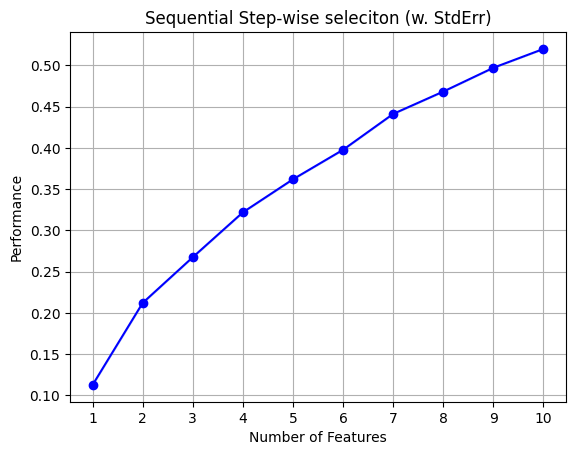

In [60]:
# Sequential Forward Floating Selection(sffs)
sffs = SFS(LinearRegression(),
         k_features=(1,10),
         forward=True,
         floating=True,
         cv=0)
sffs.fit(X, y)
sffs.k_feature_names_

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig3 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Step-wise seleciton (w. StdErr)')
plt.grid()
plt.show()

###Filter methods

#Feature extraction

##PCA

In [2]:
# Perform a PCA
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

y_train_list = y_train['label'].tolist()
print(y_train_list)

NameError: name 'decomposition' is not defined

# Classifiers

**Basic Classifiers**

NameError: name 'X_train_pca' is not defined

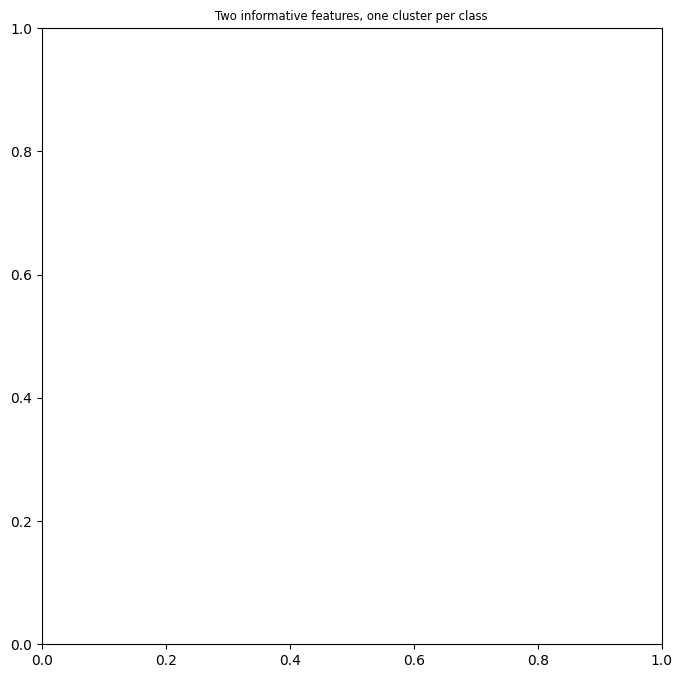

In [11]:
# # General packages
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# from sklearn import metrics

# # Metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# # Basic Classifiers
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

# Linear classifier
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative features, one cluster per class",
             fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train_list,
           s=25, edgecolor='k', cmap=plt.cm.Paired)
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train_list)
y_pred = lda.predict(X_train_pca)
colorplot(lda, ax, X_train_pca[:, 0], X_train_pca[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X_train_pca.shape[0], (y_train_list != y_pred).sum()))


**Basic classifiers: Gaussian, LDA, QDA, Logistic regression, SDG, KNN & Decision Tree**

In [12]:
# Plot several basic classifiers and plot the result. Define misclasses
clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),KNeighborsClassifier(),DecisionTreeClassifier()]
Xs = X_train_pca
Ys = y_train_list
clfs_fit = list()

# First make a plot without classifiers:
fig = plt.figure(figsize=(21,3*len(clsfs)))
num = 0  # Iteration number for the subplots

for num in range(0,7):
    ax = fig.add_subplot(21, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

# Fit the classifiers and add them to the plot
num=0
Xt=list()
Yt=list()
for clf in clsfs:
    # Fit classifier
    clf.fit(Xs,Ys)
    y_pred=clf.predict(Xs)
    # Predict labels using fitted classifier

    # Make scatterplot of features
    ax = fig.add_subplot(3, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, Xs[:,0], Xs[:,1])
    # Add overlay through colorplot function
    t=(f"{clf}, Misclass: %d / %d" % ((Ys!=y_pred).sum(), Xs.shape[0]))
    ax.set_title(t)
    num+=1

    clfs_fit.append(clf)
    Xt.append(Xs)
    Yt.append(Ys)


NameError: name 'X_train_pca' is not defined

**KNN**

In [13]:
# Fit kNN
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_pca, y_train)
score_train = knn.score(X_train_pca, y_train)
score_test = knn.score(X_test_pca, y_test)

# Print result
print(f"Training result: {score_train}")
print(f"Test result: {score_test}")

NameError: name 'X_train_pca' is not defined

## Test the metrics on the used classifiers

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

df_data = pd.DataFrame(data)
# X1 = df_data.iloc[:, 1:]        # Feature set
y_truth = df_data.iloc[:, :1]   # Classification Benign/Malignant
# gnb = GaussianNB()
# gnb = gnb.fit(X1, y_truth)
# y_pred = gnb.predict(X1)
all_results={}

for clf, X1, Y1 in zip(clfs_fit, Xt, Yt):
    y_pred=clf.predict(X1)

    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(X1)[:, 1]
    else:
        y_score = y_pred

    # The hasattr function checks whether an object, function or package has
    # a certain attribute. This attribute can be a subfunction, or again an
    # object or function, but also things like scalars or strings.

    auc_score=metrics.roc_auc_score(Y1, y_score)
    accuracy=metrics.accuracy_score(Y1, y_pred)
    F1=metrics.f1_score(Y1,y_pred)
    precision=metrics.precision_score(Y1,y_pred)
    recall=metrics.recall_score(Y1, y_pred)
    # accuracy, AUC, f1score, precision, recall
    result = [auc_score,accuracy,F1,precision,recall]
    all_results[clf]=result

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(Y1, y_score)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {clf}')
    plt.legend(loc="lower right")
    plt.show()

results_pd = pd.DataFrame(all_results)
results_pd.index = ['auc','accuracy','F1','precision','recall']
results_pd
## transpose possible if we want the axes different
# results_trans=results_pd.transpose()
# results_trans